## VRP
reference: https://en.wikipedia.org/wiki/Vehicle_routing_problem

![image](Figure_illustrating_the_vehicle_routing_problem.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def generate_data():
    size = 5
    X = np.random.random(size)
    Y = np.random.random(size)

    plt.figure('data')
    plt.scatter(X,Y,alpha=0.25)
    plt.show()

    data = pd.DataFrame({'X':X, 'Y':Y})
    data.index.name = 'id'
    data.head()
    data.to_csv('data/coordnates.csv')

generate_data()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
coordinates = pd.read_csv('data/coordnates.csv')
coordinates = {str(int(_id)):(x,y) for _id, x, y in coordinates[['id', 'X', 'Y']].values}
coordinates

{'0': (0.3391090519355644, 0.6709945940267844),
 '1': (0.4117497416473158, 0.6623894964845978),
 '2': (0.450889234526098, 0.7746534415638968),
 '3': (0.649256722326975, 0.6834766320725209),
 '4': (0.4192008885430583, 0.7430262387610672)}

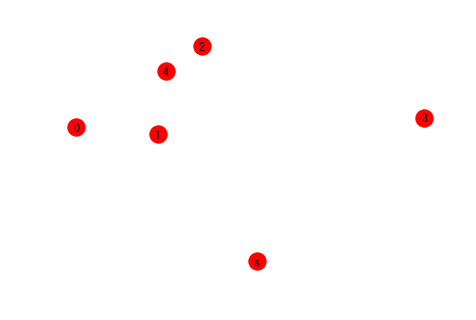

In [3]:
import networkx as nx
coordinates['s'] = (0.5, 0.5)
graph = nx.Graph()
graph.add_nodes_from(coordinates.keys())
nx.draw(graph, coordinates, with_labels=True)

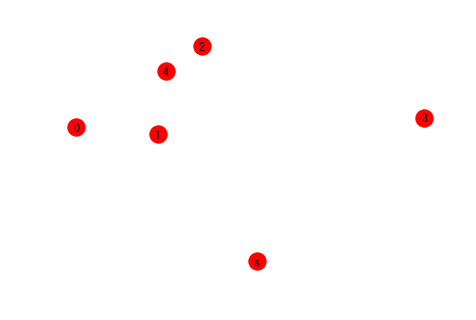

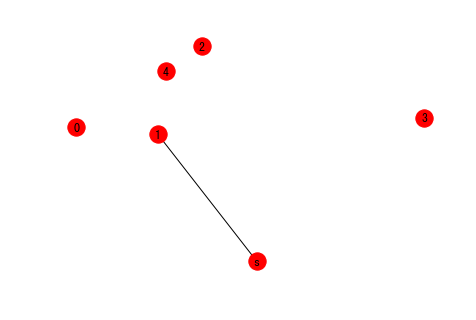

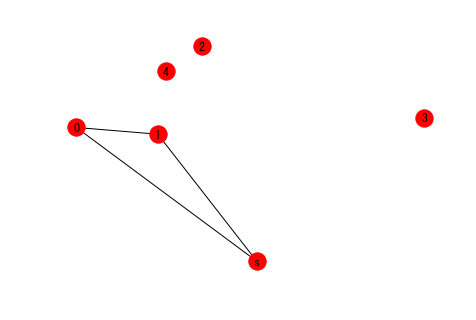

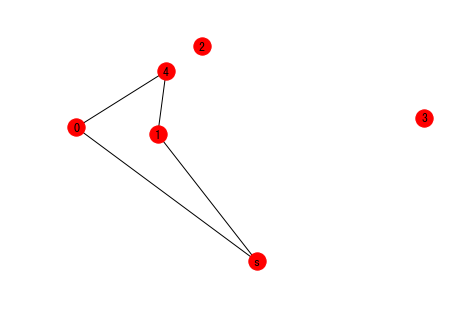

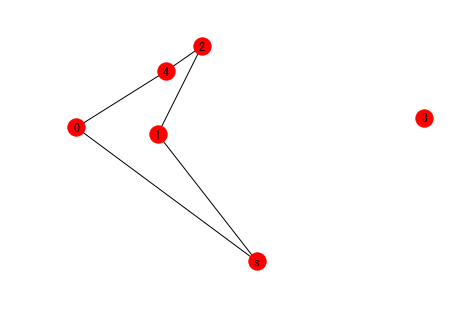

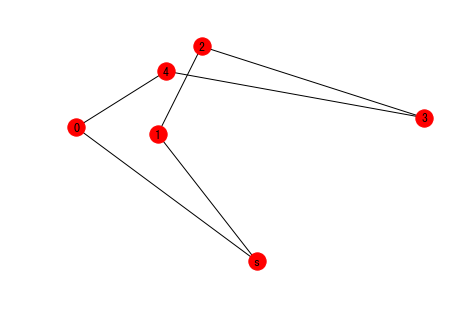

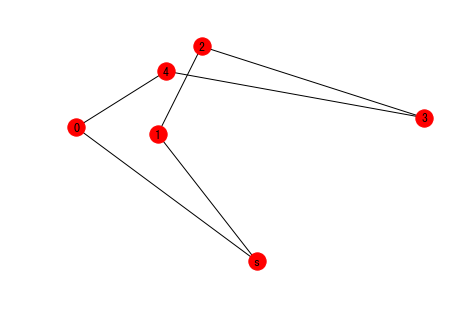

[('1', 's'), ('s', '0'), ('0', '4'), ('2', '1'), ('4', '3'), ('3', '2')]

In [4]:
from functools import lru_cache
from math import sqrt
import debug_tools
import time

@lru_cache(15*15)
def get_distance(point1:str, point2:str):
    global coordinates
    x1, y1 = coordinates[point1]
    x2, y2 = coordinates[point2]
    return sqrt((x1-x2)**2 + (y1-y2)**2)

# @debug_tools.debug_print
def get_distance_shape(point:str, trace:list):
    # trace is a list of edges
    # edge = (point1, point2)
    
    # 到一个edge的两个点距离之和最小
    closest_edge = min(trace, key = lambda e:get_distance(point, e[0]) + get_distance(point, e[1])) 
    # 如果把<a,b> 替换成 <a,c>, <c,d> 路程会增加多少
    distance_increase = get_distance(closest_edge[0], point) + get_distance(closest_edge[1], point) - get_distance(*closest_edge) 
    return distance_increase, closest_edge, point

# @debug_tools.debug_print
def visulize_trace(trace):
    global coordinates
    edges = {s:[e] for s, e in trace}
    graph = nx.Graph(edges)
    graph.add_nodes_from(coordinates.keys())
    nx.draw(graph, coordinates, with_labels=True)
    plt.show()
    
    
    
# @debug_tools.debug_print
def find_best_trace(coordnates, trace=[('s', 's')]):
    visulize_trace(trace)
    if not coordnates:
        return trace
    
    else:
        distance_increase, closest_edge, closest_point = min([get_distance_shape(p, trace) for p in coordnates], 
                                              key = lambda x:x[0])
#         print(distance_increase, closest_edge, closest_point)
        coordnates.remove(closest_point)
        trace.remove(closest_edge)
        trace += [(closest_edge[0], closest_point), (closest_point, closest_edge[1])]
        return find_best_trace(coordnates, trace)

need_visited = [e for e in coordinates.keys() if e != 's']
best_trace = find_best_trace(need_visited)
visulize_trace(best_trace)
best_trace

In [5]:
city_coordinates = get_coordination_dict(coordination_source)
city_names = list(city_coordinates.keys())

city_graph = nx.Graph()
city_graph.add_nodes_from(city_names)

nx.draw(city_graph, city_coordinates, with_labels=True, node_size=20)

NameError: name 'get_coordination_dict' is not defined